# ``UNet`` demo

The UNet is a classic go-to for semantic segmentation. To demonstrate it, we can use the VOCSegmentation dataset, which we can access through ``torchvision``.

To demonstrate how to use the model, we will use a brain MRI image segmentation dataset available on Kaggle, [here](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation).

In [38]:
from pathlib import Path

data_dir = Path("/Users/jimdenholm/brain-mri/kaggle_3m/").resolve()

Now, let's get the images and targets as lists of paths. We will stick the data in a ``pandas.DataFrame`` to make it easier to split and examine, etc.

In [39]:
from torch_tools.file_utils import traverse_directory_tree

all_files = list(
    filter(
        lambda x: x.suffix == ".tif",
        traverse_directory_tree(data_dir),
    )
)

images = sorted(
    filter(lambda x: "mask" not in x.name, all_files),
    key=lambda x: x.name,
)

targets = sorted(
    filter(lambda x: "mask" in x.name, all_files),
    key=lambda x: x.name.replace("_mask", ""),
)

# Make sure the target and image names all match
assert all(map(lambda x: x[0].stem in x[1].stem, zip(images, targets)))

Now, let's put the image and target paths together in a ``pandas.DataFrame``.

In [40]:
from pandas import DataFrame

data = DataFrame(columns=["image", "target"], data=zip(images, targets))

valid_split = data.sample(frac=0.2, random_state=123)
train_split = data.loc[~data.index.isin(valid_split.index)]

print(train_split.shape, valid_split.shape)

(3143, 2) (786, 2)


Now we create datsets from the images.

In [41]:
from skimage.io import imread
from torchvision.transforms import Compose, ToTensor

import matplotlib.pyplot as plt

from torch_tools import DataSet
from torch_tools.torch_utils import target_from_mask_img


image_tfms = Compose([imread, ToTensor()])
target_tfms = Compose(
    [imread, ToTensor(), lambda x: target_from_mask_img(x.squeeze(), 2)],
)


train_set = DataSet(
    inputs=train_split.image.to_list(),
    targets=train_split.target.to_list(),
    input_tfms=image_tfms,
    target_tfms=target_tfms,
)

valid_set = DataSet(
    inputs=train_split.image.to_list(),
    targets=train_split.target.to_list(),
    input_tfms=image_tfms,
    target_tfms=target_tfms,
)

Let's plot an example image–target pair.

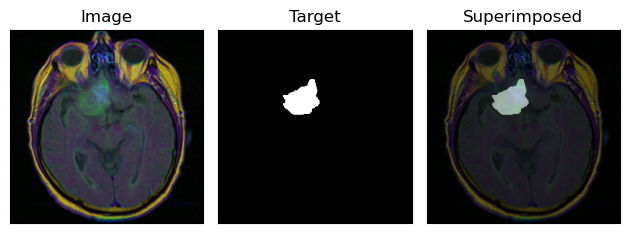

In [45]:
img, tgt = train_set[2]

tgt = tgt.argmax(dim=0)


figure, axes = plt.subplots(1, 3)

axes[0].imshow(img.permute(1, 2, 0))
axes[1].imshow(tgt, cmap="Greys_r")

axes[2].imshow(img.permute(1, 2, 0))
axes[2].imshow(tgt, cmap="Greys_r", alpha=0.5)


for axis, title in zip(axes.ravel(), ["Image", "Target", "Superimposed"]):
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title(title)

figure.tight_layout()

Now we can wrap the ``DataSet``s in ``DataLoader``s and set about training the model.

In [51]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

Now we need a model, optimiser, loss function and training loops.

In [ ]:
from torch.optim import Adam
from torch.nn import BCELoss

from torch_tools import UNet

model = UNet(
    in_chans=3,
    out_chans=2,
    features_start=16,
)

optimiser = Adam(model.parameters(), lr=1e-4)

loss_func = BCELoss()